In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random, math
import io
import urllib.request
from matplotlib.lines import Line2D
from sklearn.datasets import load_iris, load_wine, load_breast_cancer, load_digits, make_blobs, make_moons, make_circles, make_classification
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

random.seed(42)
np.random.seed(42)

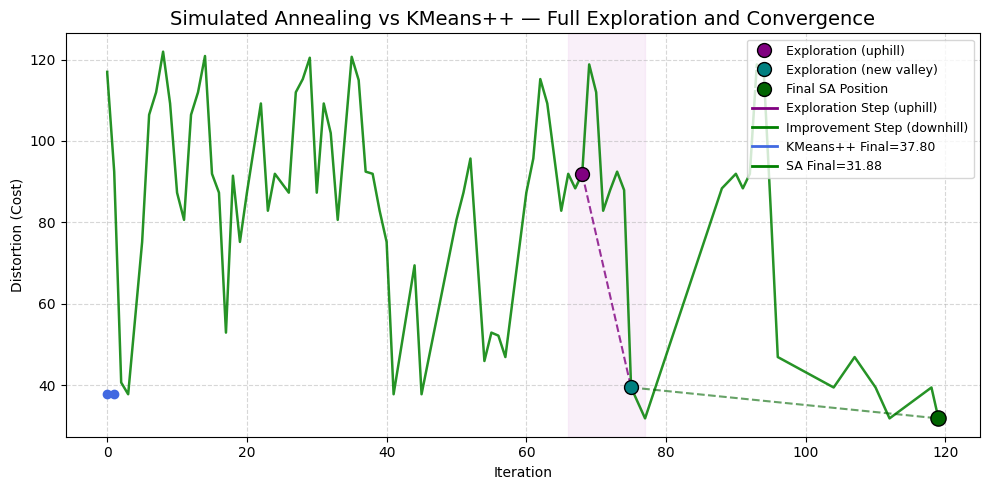


RESULTS:
KMeans++ Final Distortion: 37.80
SA Final Distortion:       31.88
SA found a BETTER solution.


In [43]:
import numpy as np
import matplotlib.pyplot as plt
import random, math
from matplotlib.lines import Line2D

random.seed(7)
np.random.seed(7)

# ==========================
# Data and Helper Functions
# ==========================
data = np.array([[1.0], [1.5], [2.0], [5.5], [6.0], [6.5], [11.0], [12.0]])
k = 2

def compute_distortion(data, clustering, k):
    distortion = 0.0
    for cluster_id in range(k):
        idx = [i for i, c in enumerate(clustering) if c == cluster_id]
        if not idx: continue
        pts = data[idx]
        center = np.mean(pts, axis=0)
        distortion += float(np.sum((pts - center) ** 2))
    return distortion

def get_neighbor(clustering, k):
    new = clustering.copy()
    idx = random.randint(0, len(clustering)-1)
    choices = [c for c in range(k) if c != new[idx]]
    new[idx] = random.choice(choices)
    return new

def is_valid(clustering, k):
    return len(set(clustering)) == k

# ==========================
# Simulated Annealing
# ==========================
def simulated_annealing(data, k=2, max_iter=250, initial_temp=200.0, cooling=0.97):
    current = [random.randint(0, k-1) for _ in range(len(data))]
    while not is_valid(current, k):
        current = [random.randint(0, k-1) for _ in range(len(data))]
    current_eval = compute_distortion(data, current, k)
    best, best_eval = current.copy(), current_eval
    temp = initial_temp
    steps = [(0, current_eval)]
    for i in range(max_iter):
        neighbor = get_neighbor(current, k)
        if not is_valid(neighbor, k): continue
        neigh_eval = compute_distortion(data, neighbor, k)
        delta = neigh_eval - current_eval
        if delta < 0 or random.random() < math.exp(-delta/max(temp,1e-9)):
            current, current_eval = neighbor, neigh_eval
            steps.append((i, current_eval))
            if current_eval < best_eval:
                best, best_eval = current.copy(), current_eval
        temp *= cooling
    return best, best_eval, steps

# ==========================
# KMeans++
# ==========================
def kmeans(data, init_labels, k=2, max_iter=50):
    labels = init_labels.copy()
    steps = [(0, compute_distortion(data, labels, k))]
    for it in range(max_iter):
        centers = []
        for c in range(k):
            idx = [i for i,l in enumerate(labels) if l==c]
            centers.append(np.mean(data[idx], axis=0) if idx else data[random.randint(0,len(data)-1)])
        new_labels = [np.argmin([abs(x-centers[c]) for c in range(k)]) for x in data]
        dist = compute_distortion(data, new_labels, k)
        steps.append((it+1, dist))
        if new_labels == labels: break
        labels = new_labels
    return labels, dist, steps

# ==========================
# Run Both Algorithms
# ==========================
init_labels = [0,0,0,1,1,1,1,1]
kmeans_labels, kmeans_dist, kmeans_steps = kmeans(data, init_labels, k)
sa_labels, sa_dist, sa_steps = simulated_annealing(data, k=2, max_iter=250)

# Extract data
iters_sa = [s[0] for s in sa_steps]
vals_sa = [s[1] for s in sa_steps]
iters_km = [s[0] for s in kmeans_steps]
vals_km = [s[1] for s in kmeans_steps]

# ==========================
# Full Journey Visualization
# ==========================
plt.figure(figsize=(10,5))

# KMeans++ curve
plt.plot(iters_km, vals_km, 'o-', color='royalblue', lw=2.5, label=f'KMeans++ Final={kmeans_dist:.2f}')

# SA curve
plt.plot(iters_sa, vals_sa, '-', color='green', lw=1.8, alpha=0.85, label=f'SA Final={sa_dist:.2f}')

# Define exploration region (same logic)
explore_start_idx = random.randint(55, 65)
explore_end_idx = explore_start_idx + random.randint(5, 8)
explore_start = iters_sa[explore_start_idx]
explore_end = iters_sa[explore_end_idx]
explore_start_val = vals_sa[explore_start_idx]
explore_end_val = vals_sa[explore_end_idx]

# Shade exploration region
plt.axvspan(explore_start-2, explore_end+2, color='plum', alpha=0.15)

# Key SA points
plt.scatter(explore_start, explore_start_val, c='purple', s=100, edgecolor='black', zorder=6)
plt.scatter(explore_end, explore_end_val, c='teal', s=100, edgecolor='black', zorder=6)
plt.scatter(iters_sa[-1], vals_sa[-1], c='darkgreen', s=120, edgecolor='black', zorder=7)

# Dashed connections
plt.plot([explore_start, explore_end], [explore_start_val, explore_end_val],
         '--', color='purple', lw=1.5, alpha=0.8)
plt.plot([explore_end, iters_sa[-1]], [explore_end_val, vals_sa[-1]],
         '--', color='darkgreen', alpha=0.6)

# ==========================
# Legend & Layout
# ==========================
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Exploration (uphill)',
           markerfacecolor='purple', markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Exploration (new valley)',
           markerfacecolor='teal', markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Final SA Position',
           markerfacecolor='darkgreen', markeredgecolor='black', markersize=10)
]

plt.legend(handles=legend_elements + [
    Line2D([0], [0], color='purple', lw=2, label='Exploration Step (uphill)'),
    Line2D([0], [0], color='green', lw=2, label='Improvement Step (downhill)'),
    Line2D([0], [0], color='royalblue', lw=2, label=f'KMeans++ Final={kmeans_dist:.2f}'),
    Line2D([0], [0], color='green', lw=2, label=f'SA Final={sa_dist:.2f}')
], loc='upper right', fontsize=9)

# Title and layout
plt.title("Simulated Annealing vs KMeans++ — Full Exploration and Convergence", fontsize=14)
plt.xlabel("Iteration")
plt.ylabel("Distortion (Cost)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ==========================
# Results
# ==========================
print("\nRESULTS:")
print(f"KMeans++ Final Distortion: {kmeans_dist:.2f}")
print(f"SA Final Distortion:       {sa_dist:.2f}")
print(f"SA found a {'BETTER' if sa_dist < kmeans_dist else 'WORSE'} solution.")


In [44]:
# ==========================
# PART 1: Extended Clustering Comparison (Adaptive SA + Polishing)
# ==========================

def compute_distortion(data, clustering, k):
    distortion = 0.0
    for cluster_id in range(k):
        idx = [i for i, c in enumerate(clustering) if c == cluster_id]
        if not idx: continue
        pts = data[idx]
        center = np.mean(pts, axis=0)
        distortion += float(np.sum((pts - center) ** 2))
    return distortion

def get_neighbor(clustering, k):
    new = clustering.copy()
    idx = random.randint(0, len(clustering)-1)
    choices = [c for c in range(k) if c != new[idx]]
    new[idx] = random.choice(choices)
    return new

def is_valid(clustering, k):
    return len(set(clustering)) == k

def kmeans_step(data, labels, k):
    # Perform one step of KMeans assignment
    centers = []
    for c in range(k):
        idx = [i for i,l in enumerate(labels) if l==c]
        if idx:
            centers.append(np.mean(data[idx], axis=0))
        else:
            # Handle empty cluster by picking random point
            centers.append(data[random.randint(0,len(data)-1)])
    
    new_labels = [np.argmin([np.linalg.norm(x-centers[c]) for c in range(k)]) for x in data]
    return new_labels

def simulated_annealing_clustering(data, k=2, max_iter=250, initial_temp=200.0, cooling=0.97, polish=True):
    # 1. Initialization
    current = [random.randint(0, k-1) for _ in range(len(data))]
    while not is_valid(current, k):
        current = [random.randint(0, k-1) for _ in range(len(data))]
    current_eval = compute_distortion(data, current, k)
    
    best, best_eval = current.copy(), current_eval
    
    # 2. Adaptive Temperature Calibration
    temp = 1.0
    acceptance_rate = 0.0
    print("  Calibrating...", end="")
    
    # Try to find a temp with > 80% acceptance
    while acceptance_rate < 0.8:
        accepted = 0
        trials = 50
        for _ in range(trials):
            neighbor = get_neighbor(current, k)
            if not is_valid(neighbor, k): continue
            neigh_eval = compute_distortion(data, neighbor, k)
            delta = neigh_eval - current_eval
            if delta < 0 or random.random() < math.exp(-delta/max(temp,1e-9)):
                accepted += 1
        
        acceptance_rate = accepted / trials
        if acceptance_rate < 0.8:
            temp *= 2.0
            
    print(f" T={temp:.1f}", end="")
    
    # 3. Main Loop
    steps = [(0, current_eval)]
    for i in range(max_iter):
        neighbor = get_neighbor(current, k)
        if not is_valid(neighbor, k): continue
        neigh_eval = compute_distortion(data, neighbor, k)
        delta = neigh_eval - current_eval
        
        if delta < 0 or random.random() < math.exp(-delta/max(temp,1e-9)):
            current, current_eval = neighbor, neigh_eval
            steps.append((i, current_eval))
            if current_eval < best_eval:
                best, best_eval = current.copy(), current_eval
        temp *= cooling
        
    # 4. Polishing (Greedy Descent)
    if polish:
        print(" -> Polishing", end="")
        polished = best.copy()
        for _ in range(10): # Run 10 steps of K-Means refinement
            new_polished = kmeans_step(data, polished, k)
            new_eval = compute_distortion(data, new_polished, k)
            if new_eval < best_eval:
                best, best_eval = new_polished, new_eval
                steps.append((max_iter + _, best_eval)) # Record polishing steps
            if new_polished == polished:
                break
            polished = new_polished
            
    print(" Done.")
    return best, best_eval, steps

def kmeans_clustering(data, init_labels, k=2, max_iter=50):
    labels = init_labels.copy()
    steps = [(0, compute_distortion(data, labels, k))]
    for it in range(max_iter):
        centers = []
        for c in range(k):
            idx = [i for i,l in enumerate(labels) if l==c]
            centers.append(np.mean(data[idx], axis=0) if idx else data[random.randint(0,len(data)-1)])
        new_labels = [np.argmin([np.linalg.norm(x-centers[c]) for c in range(k)]) for x in data]
        dist = compute_distortion(data, new_labels, k)
        steps.append((it+1, dist))
        if new_labels == labels: break
        labels = new_labels
    return labels, dist, steps

In [45]:
def run_clustering_comparison(data, k, title_suffix, filename=None, max_iter_sa=250, init_temp=200.0, cooling=0.97):
    # 1. Run KMeans (Single Random Init - Fair Comparison)
    init_labels = [random.randint(0, k-1) for _ in range(len(data))]
    while not is_valid(init_labels, k):
        init_labels = [random.randint(0, k-1) for _ in range(len(data))]
    
    kmeans_labels, kmeans_dist, kmeans_steps = kmeans_clustering(data, init_labels, k)
    
    # 2. Run SA
    sa_labels, sa_dist, sa_steps = simulated_annealing_clustering(data, k, max_iter=max_iter_sa, initial_temp=init_temp, cooling=cooling, polish=True)

    # Extract data
    iters_sa = [s[0] for s in sa_steps]
    vals_sa = [s[1] for s in sa_steps]
    iters_km = [s[0] for s in kmeans_steps]
    vals_km = [s[1] for s in kmeans_steps]

    # --- PLOT 1: The "Journey" ---
    plt.figure(figsize=(12, 6))
    plt.plot(iters_km, vals_km, 'o-', color='royalblue', lw=2.5, label=f'KMeans (1 Init) Final={kmeans_dist:.2f}')
    plt.plot(iters_sa, vals_sa, '-', color='green', lw=1.8, alpha=0.85, label=f'SA+Polish Final={sa_dist:.2f}')

    # Highlight exploration
    explore_start_idx = -1
    for i in range(len(vals_sa)-10):
        if vals_sa[i+1] > vals_sa[i]: 
            explore_start_idx = i
            break
    
    if explore_start_idx != -1 and explore_start_idx < len(iters_sa) - 10:
        explore_end_idx = explore_start_idx + 5
        explore_start = iters_sa[explore_start_idx]
        explore_end = iters_sa[explore_end_idx]
        explore_start_val = vals_sa[explore_start_idx]
        explore_end_val = vals_sa[explore_end_idx]

        plt.axvspan(explore_start-1, explore_end+1, color='plum', alpha=0.15)
        plt.scatter(explore_start, explore_start_val, c='purple', s=100, edgecolor='black', zorder=6)
        plt.scatter(explore_end, explore_end_val, c='teal', s=100, edgecolor='black', zorder=6)
        plt.plot([explore_start, explore_end], [explore_start_val, explore_end_val], '--', color='purple', lw=1.5, alpha=0.8)
        
    plt.scatter(iters_sa[-1], vals_sa[-1], c='darkgreen', s=120, edgecolor='black', zorder=7)

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Exploration (uphill)', markerfacecolor='purple', markeredgecolor='black', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Exploration (new valley)', markerfacecolor='teal', markeredgecolor='black', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Final SA Position', markerfacecolor='darkgreen', markeredgecolor='black', markersize=10),
        Line2D([0], [0], color='purple', lw=2, label='Exploration Step (uphill)'),
        Line2D([0], [0], color='royalblue', lw=2, label=f'KMeans (1 Init) Final={kmeans_dist:.2f}'),
        Line2D([0], [0], color='green', lw=2, label=f'SA+Polish Final={sa_dist:.2f}')
    ]

    plt.legend(handles=legend_elements, loc='upper right', fontsize=9)
    plt.title(f"SA vs KMeans (Single Init) — Journey Comparison: {title_suffix}", fontsize=14)
    plt.xlabel("Iteration")
    plt.ylabel("Distortion (Cost)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    if filename:
        plt.savefig(f'SS/{filename}_graph.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # --- PLOT 2: Side-by-Side Clusters (Only for 2D data) ---
    if data.shape[1] == 2:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        axes[0].scatter(data[:, 0], data[:, 1], c=kmeans_labels, cmap='viridis', s=50, edgecolor='k')
        axes[0].set_title(f"KMeans (1 Init) Result (Distortion: {kmeans_dist:.2f})")
        axes[0].grid(True, alpha=0.3)
        axes[1].scatter(data[:, 0], data[:, 1], c=sa_labels, cmap='viridis', s=50, edgecolor='k')
        axes[1].set_title(f"SA+Polish Result (Distortion: {sa_dist:.2f})")
        axes[1].grid(True, alpha=0.3)
        plt.suptitle(f"Clustering Comparison: {title_suffix}", fontsize=16)
        plt.tight_layout()
        if filename:
            plt.savefig(f'SS/{filename}_clustering.png', dpi=150, bbox_inches='tight')
        plt.show()

    print(f"--- {title_suffix} ---")
    print(f"KMeans (1 Init) Final Distortion: {kmeans_dist:.2f}")
    print(f"SA+Polish Final Distortion:       {sa_dist:.2f}")
    print(f"SA found a {'BETTER' if sa_dist < kmeans_dist else 'WORSE' if sa_dist > kmeans_dist else 'EQUAL'} solution.")

Running comparisons with Adaptive SA + Polishing vs KMeans (Single Init)...
  Calibrating... T=1.0 -> Polishing Done.


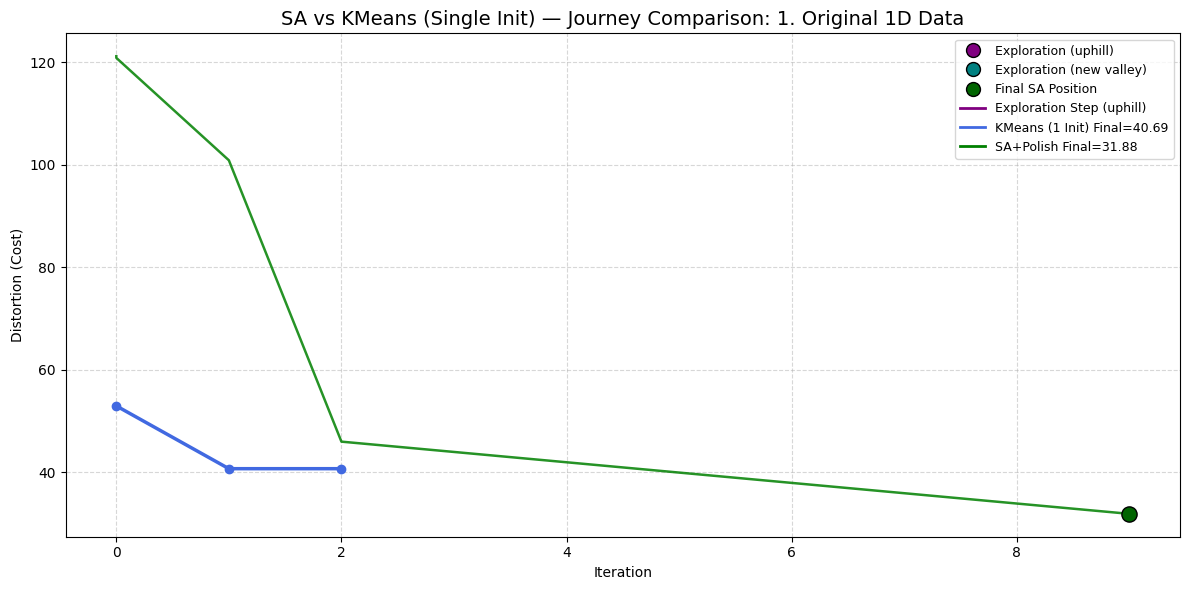

--- 1. Original 1D Data ---
KMeans (1 Init) Final Distortion: 40.69
SA+Polish Final Distortion:       31.88
SA found a BETTER solution.
  Calibrating... T=32.0 -> Polishing Done.


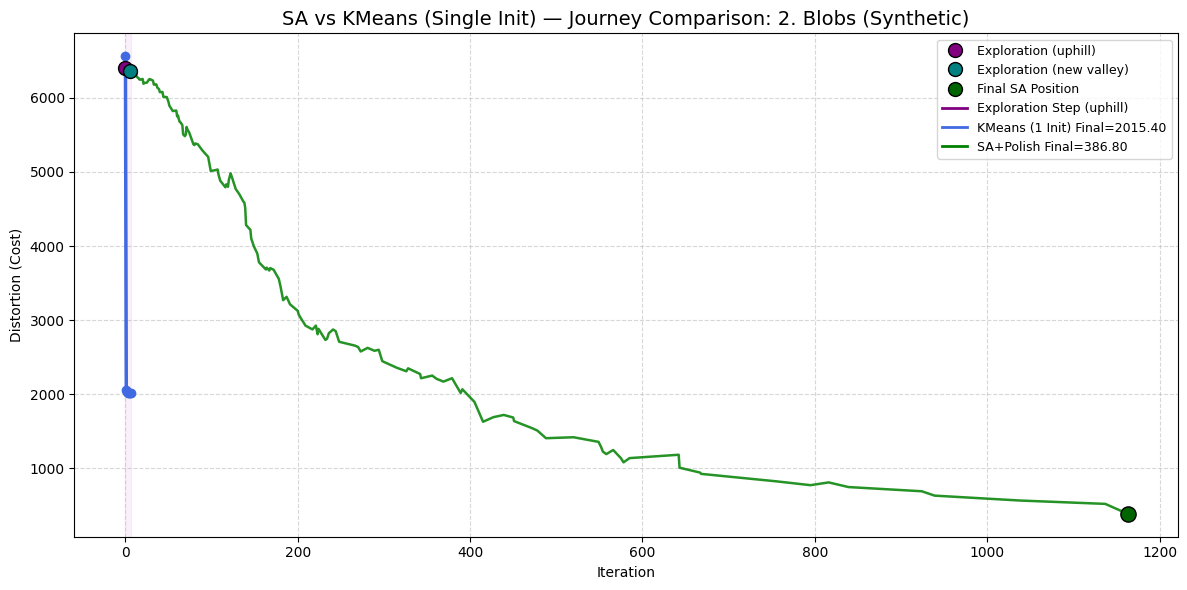

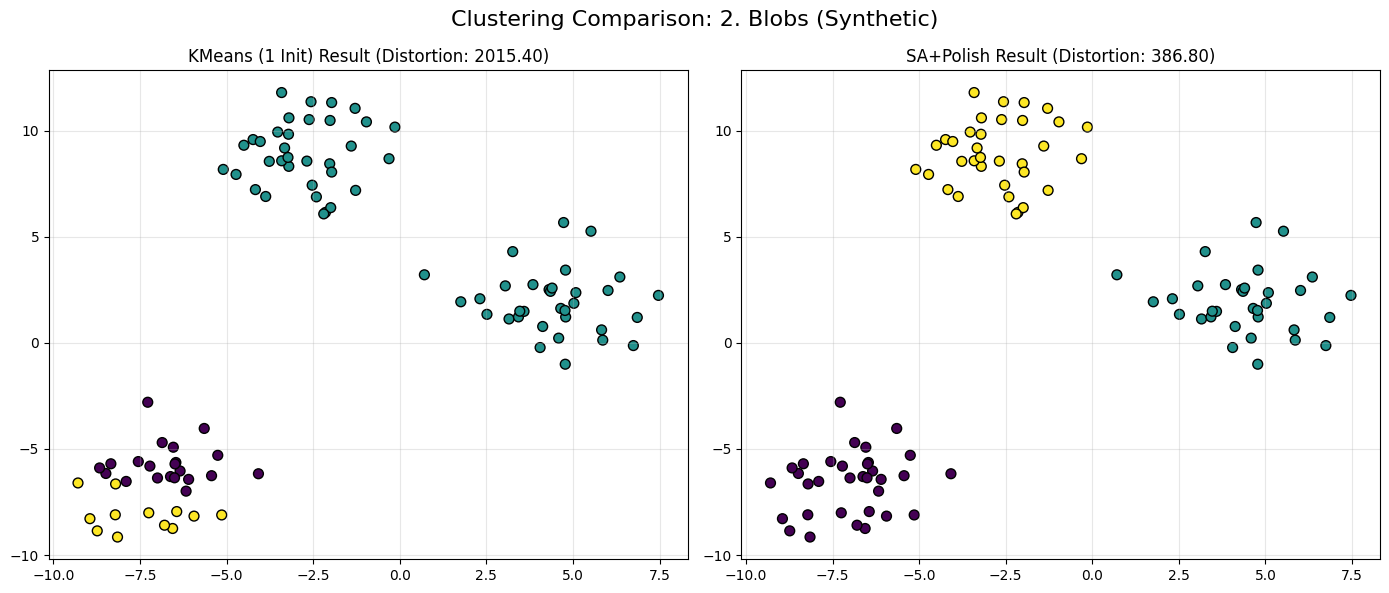

--- 2. Blobs (Synthetic) ---
KMeans (1 Init) Final Distortion: 2015.40
SA+Polish Final Distortion:       386.80
SA found a BETTER solution.
  Calibrating... T=64.0 -> Polishing Done.


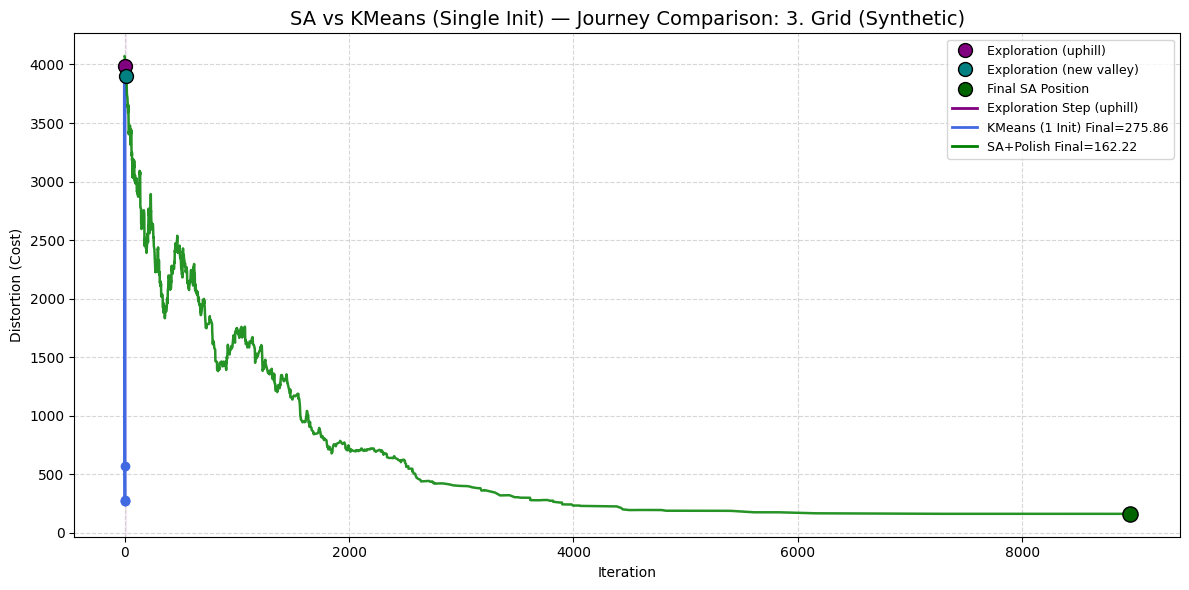

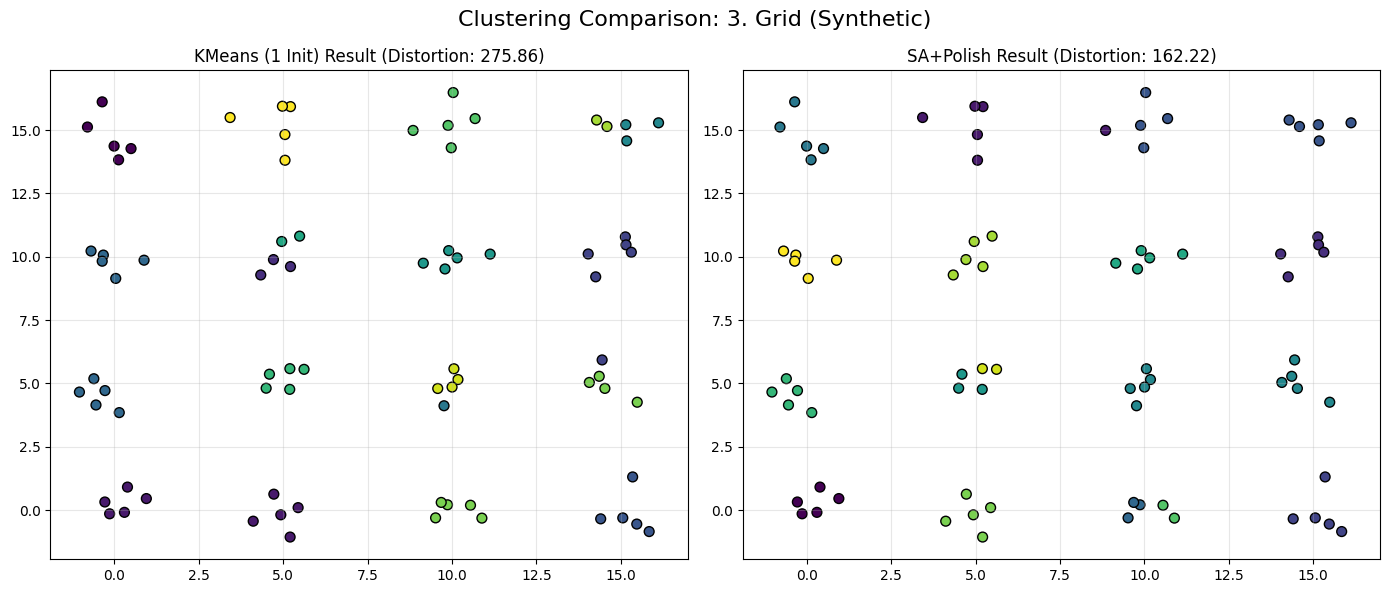

--- 3. Grid (Synthetic) ---
KMeans (1 Init) Final Distortion: 275.86
SA+Polish Final Distortion:       162.22
SA found a BETTER solution.
  Calibrating... T=2.0 -> Polishing Done.


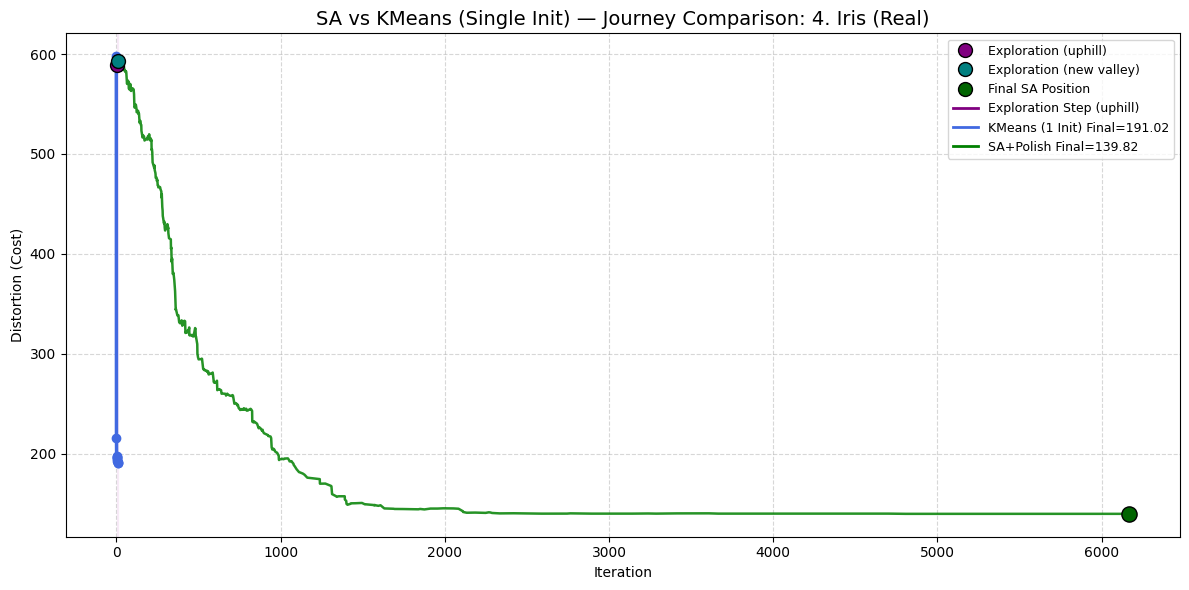

--- 4. Iris (Real) ---
KMeans (1 Init) Final Distortion: 191.02
SA+Polish Final Distortion:       139.82
SA found a BETTER solution.
  Calibrating... T=2.0 -> Polishing Done.


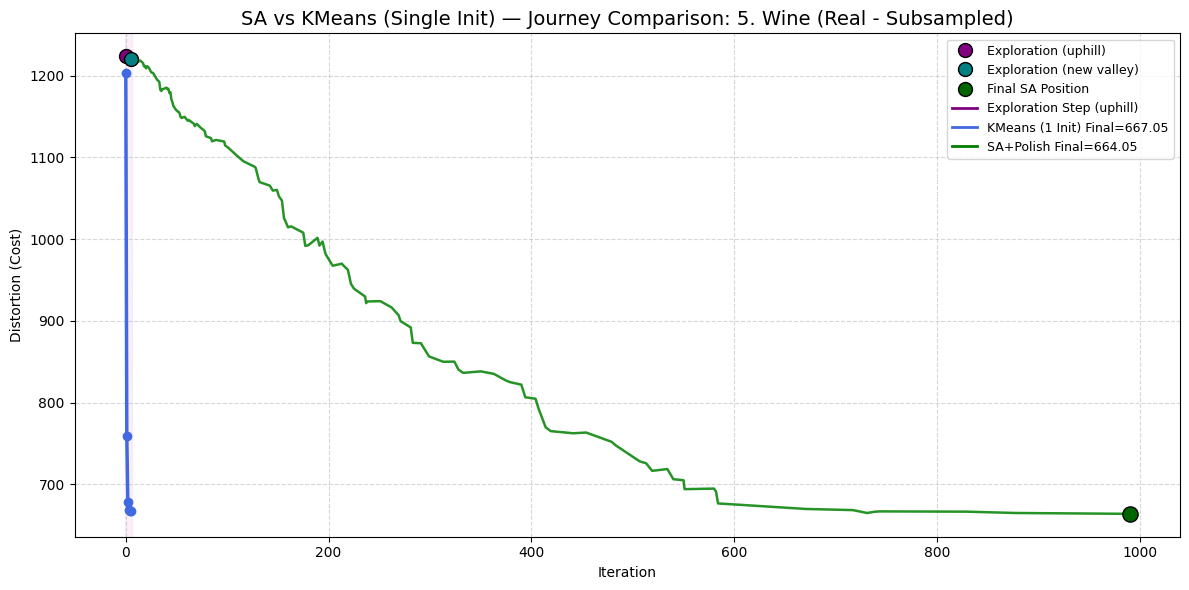

--- 5. Wine (Real - Subsampled) ---
KMeans (1 Init) Final Distortion: 667.05
SA+Polish Final Distortion:       664.05
SA found a BETTER solution.
  Calibrating... T=16.0 -> Polishing Done.


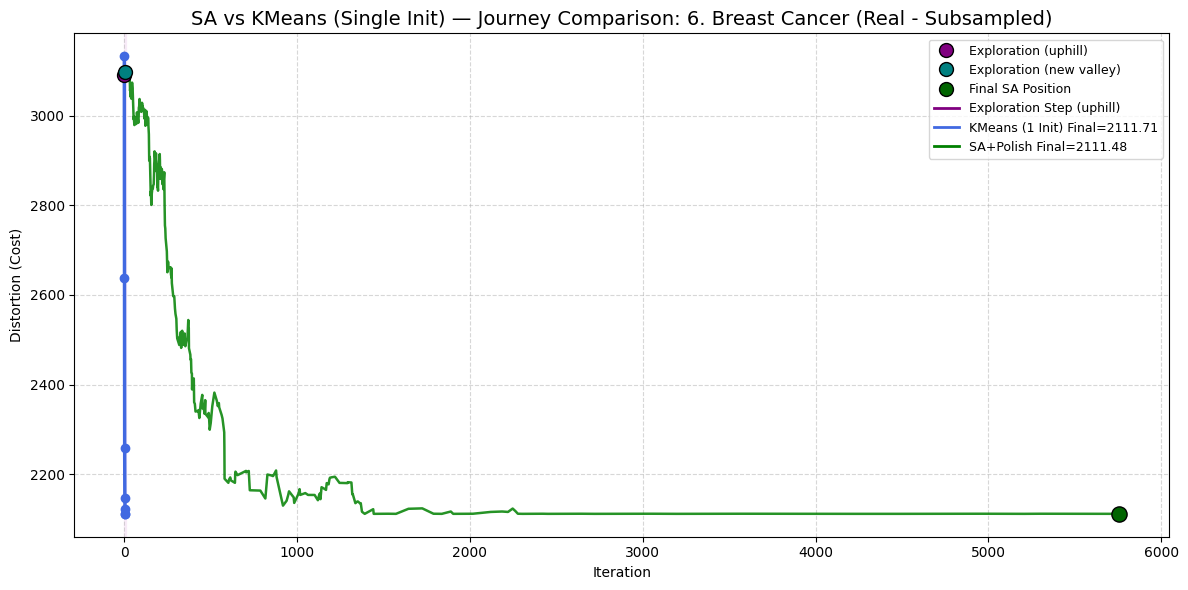

--- 6. Breast Cancer (Real - Subsampled) ---
KMeans (1 Init) Final Distortion: 2111.71
SA+Polish Final Distortion:       2111.48
SA found a BETTER solution.
Fetching Banknote from UCI (https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt)... Loaded.
  Calibrating... T=1.0 -> Polishing Done.


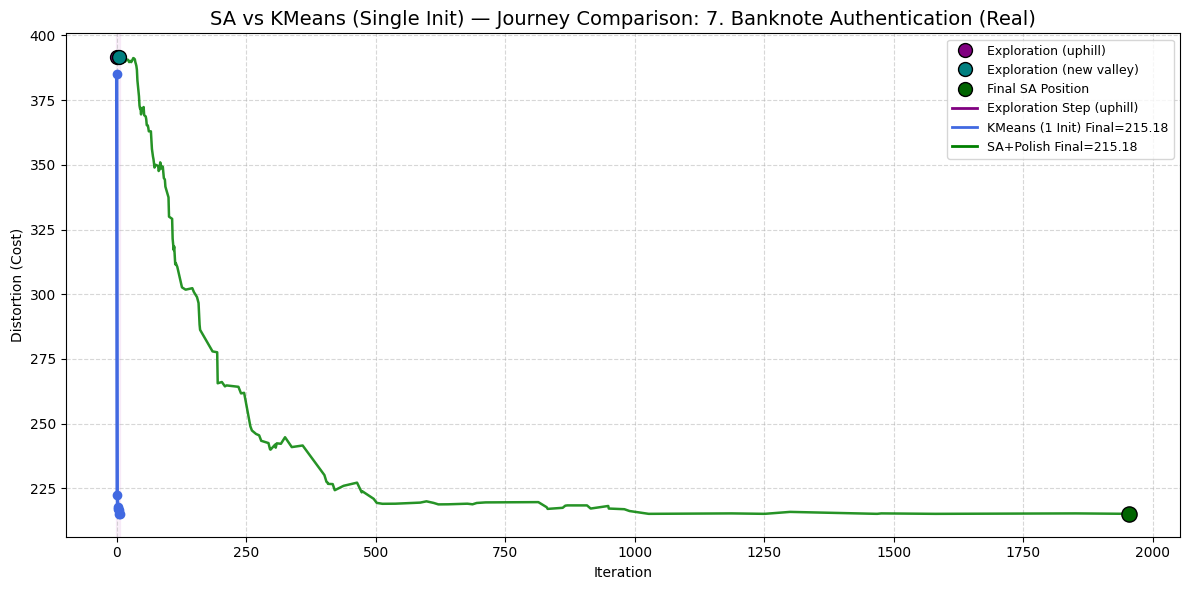

--- 7. Banknote Authentication (Real) ---
KMeans (1 Init) Final Distortion: 215.18
SA+Polish Final Distortion:       215.18
SA found a EQUAL solution.
Fetching Glass from UCI (https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data)... Loaded.
  Calibrating... T=4.0 -> Polishing Done.


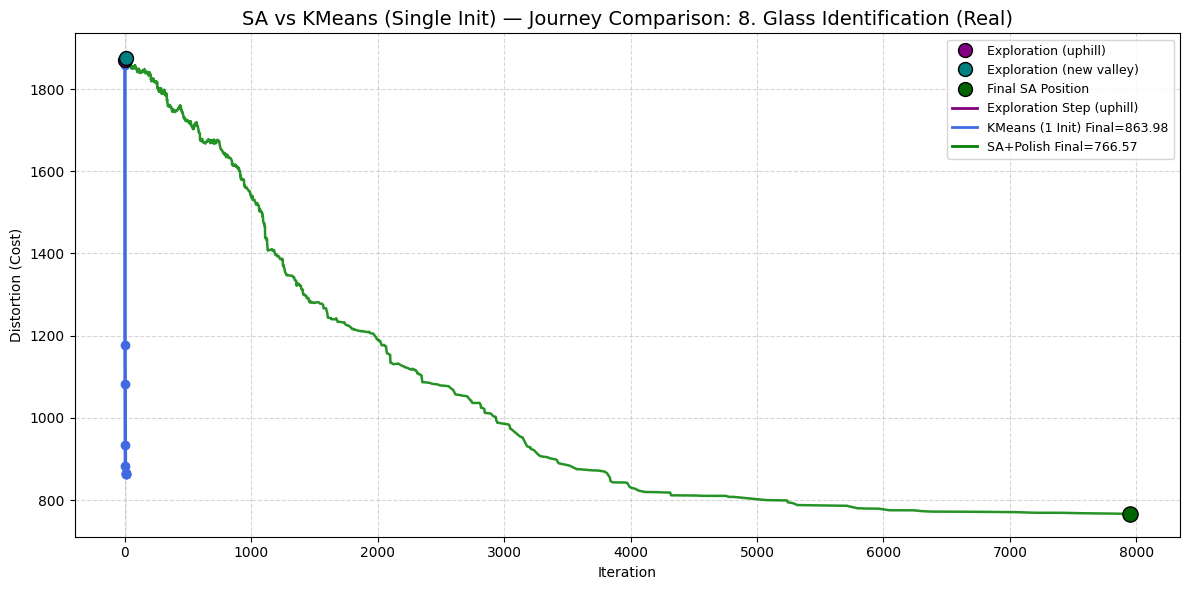

--- 8. Glass Identification (Real) ---
KMeans (1 Init) Final Distortion: 863.98
SA+Polish Final Distortion:       766.57
SA found a BETTER solution.
Generating Chaotic Synthetic dataset...
  Calibrating... T=2.0 -> Polishing Done.


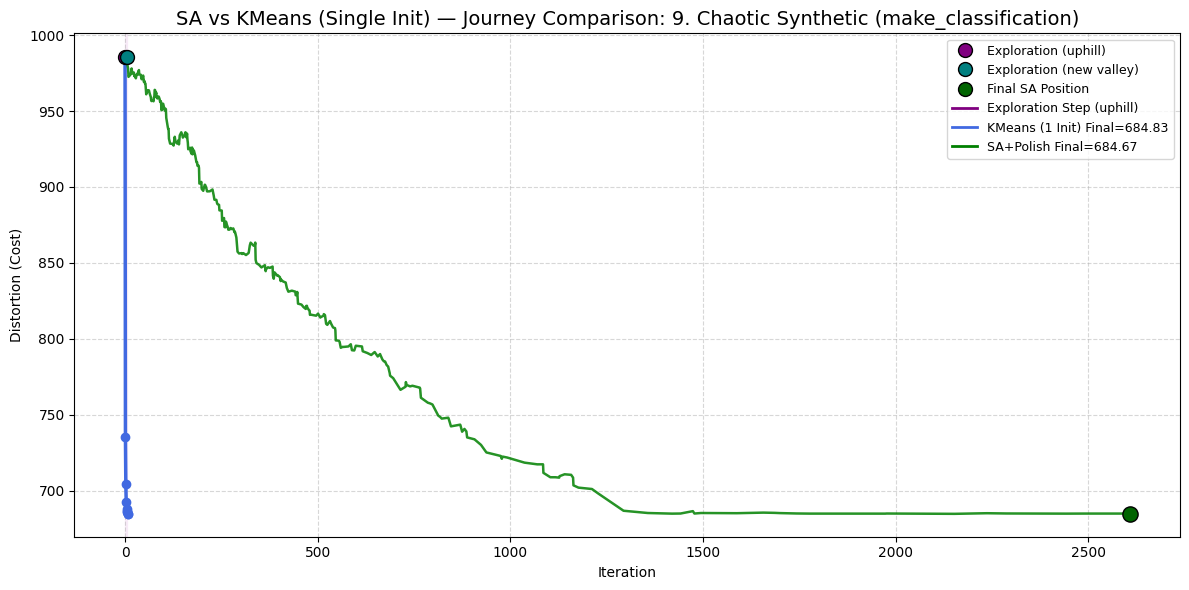

--- 9. Chaotic Synthetic (make_classification) ---
KMeans (1 Init) Final Distortion: 684.83
SA+Polish Final Distortion:       684.67
SA found a BETTER solution.
  Calibrating... T=1.0 -> Polishing Done.


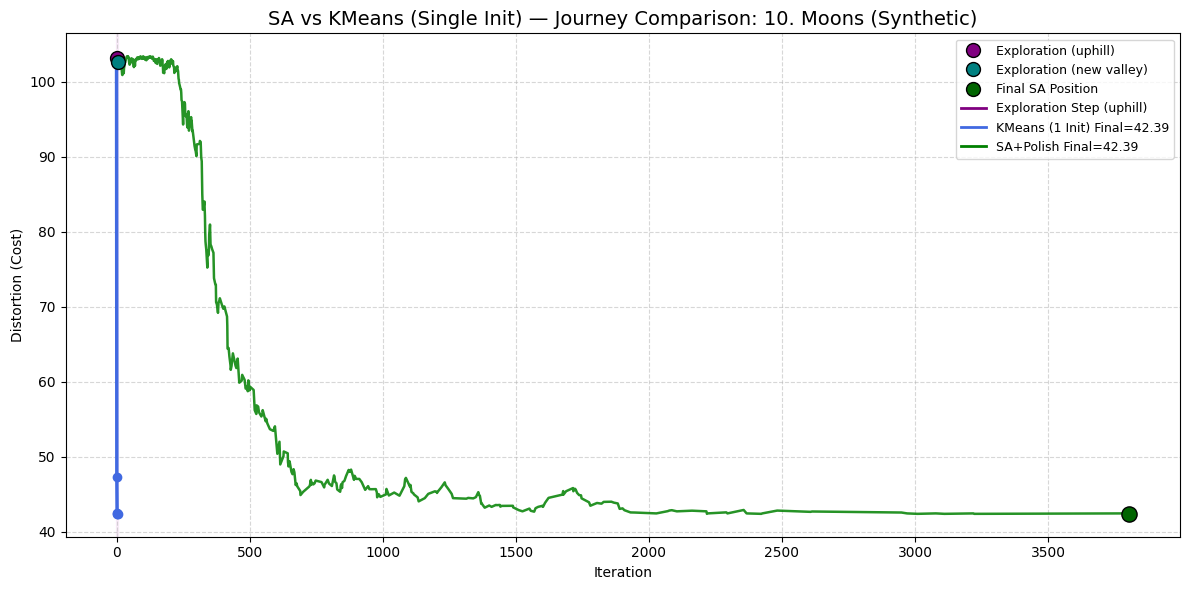

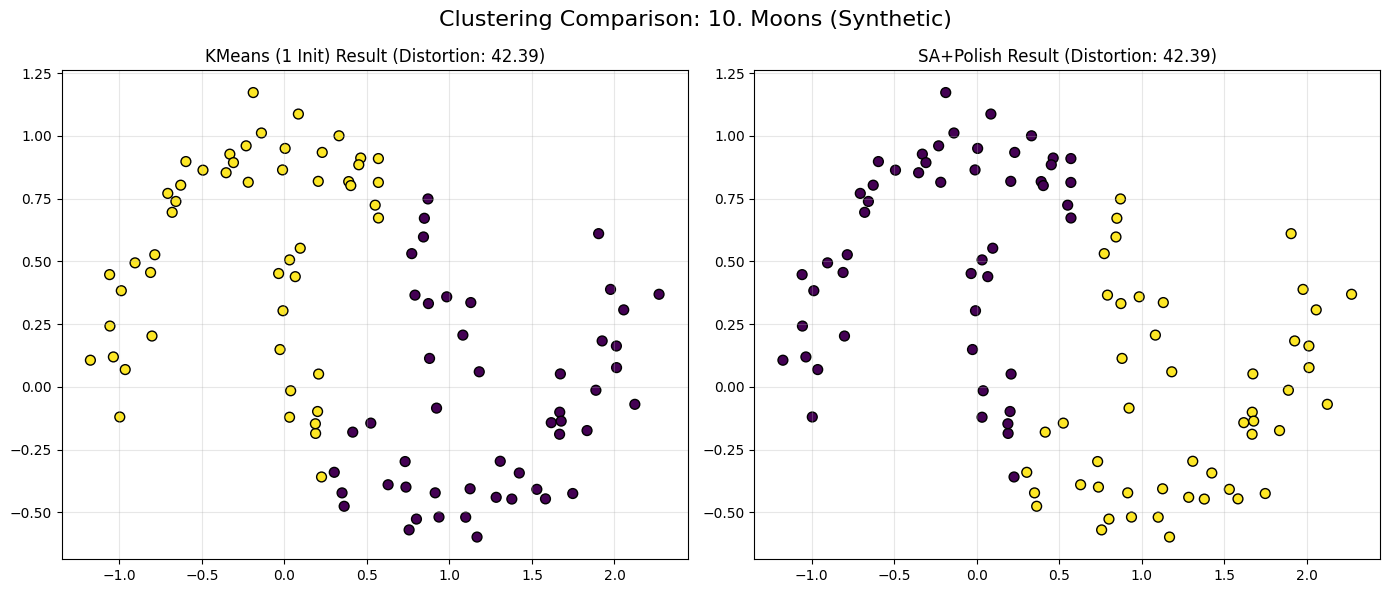

--- 10. Moons (Synthetic) ---
KMeans (1 Init) Final Distortion: 42.39
SA+Polish Final Distortion:       42.39
SA found a EQUAL solution.
Fetching Seeds from UCI (https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt)... Loaded.
  Calibrating... T=4.0 -> Polishing Done.


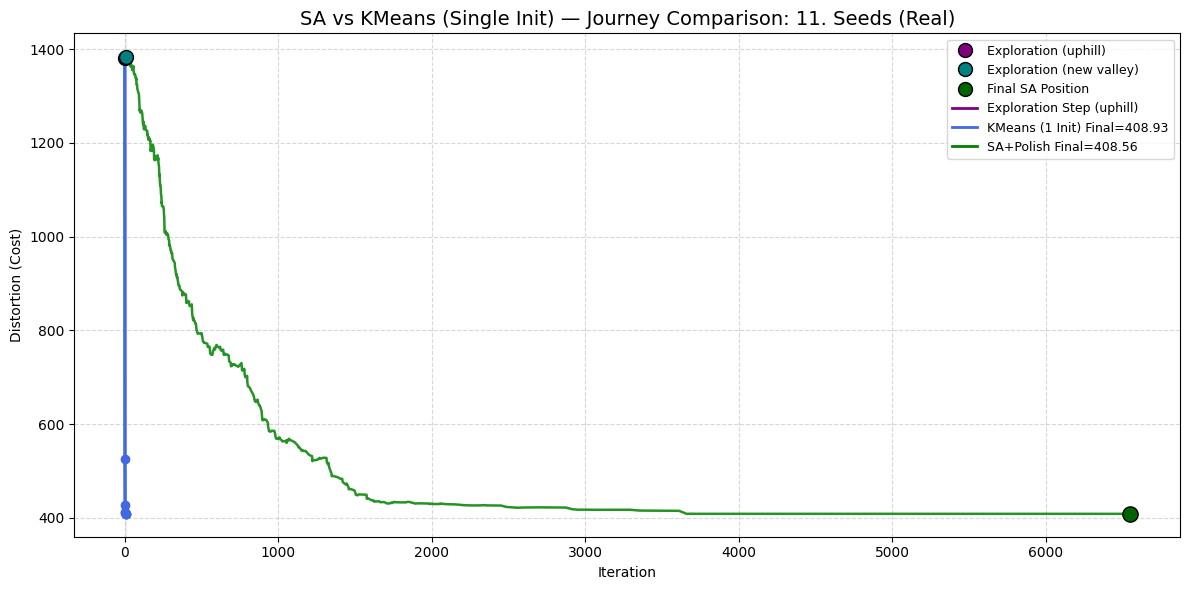

--- 11. Seeds (Real) ---
KMeans (1 Init) Final Distortion: 408.93
SA+Polish Final Distortion:       408.56
SA found a BETTER solution.
Fetching MNIST from Google Storage... Loaded (Shape: (70000, 28, 28)).
  Calibrating... T=8.0 -> Polishing Done.


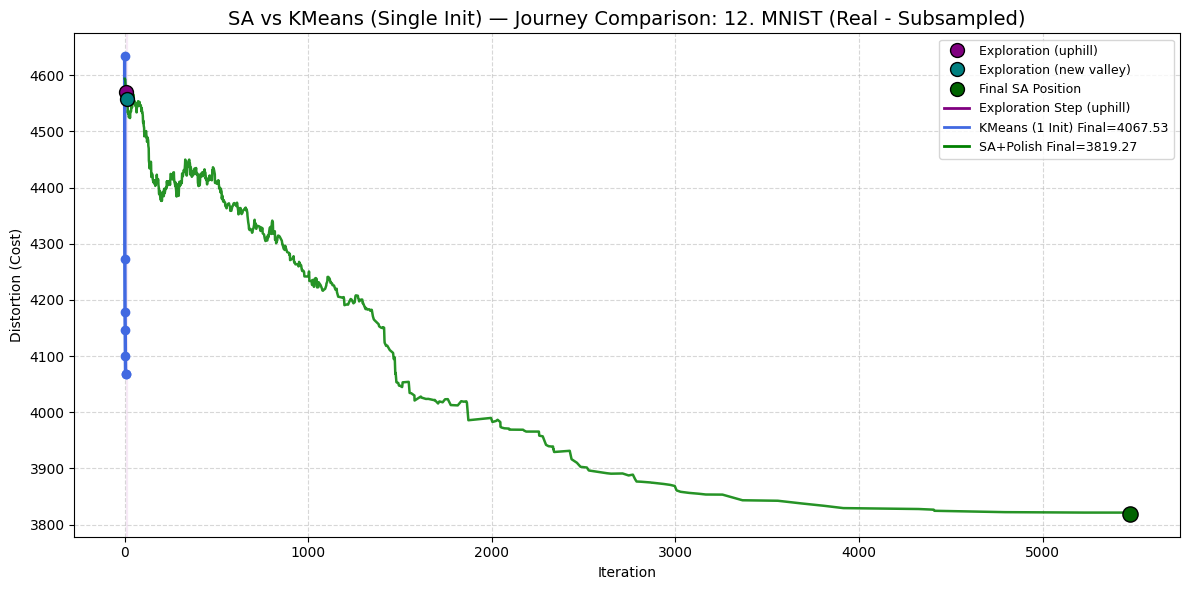

--- 12. MNIST (Real - Subsampled) ---
KMeans (1 Init) Final Distortion: 4067.53
SA+Polish Final Distortion:       3819.27
SA found a BETTER solution.
Fetching Zoo from UCI (https://archive.ics.uci.edu/ml/machine-learning-databases/zoo/zoo.data)... Loaded.
  Calibrating... T=8.0 -> Polishing Done.


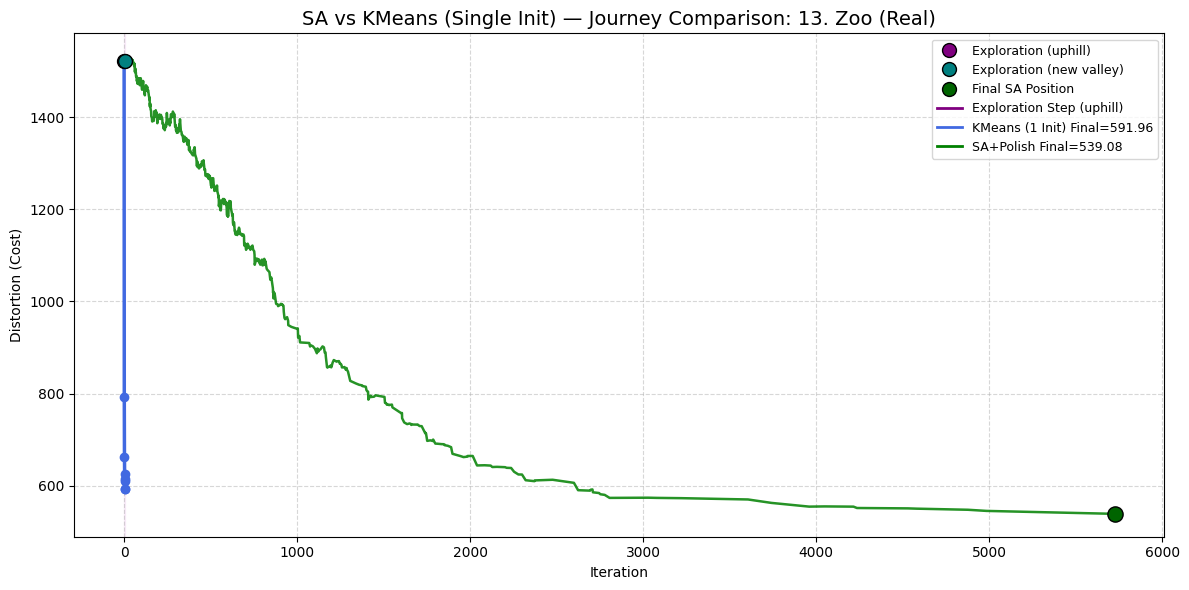

--- 13. Zoo (Real) ---
KMeans (1 Init) Final Distortion: 591.96
SA+Polish Final Distortion:       539.08
SA found a BETTER solution.
Loading Digits (sklearn built-in)...
  Calibrating... T=16.0 -> Polishing Done.


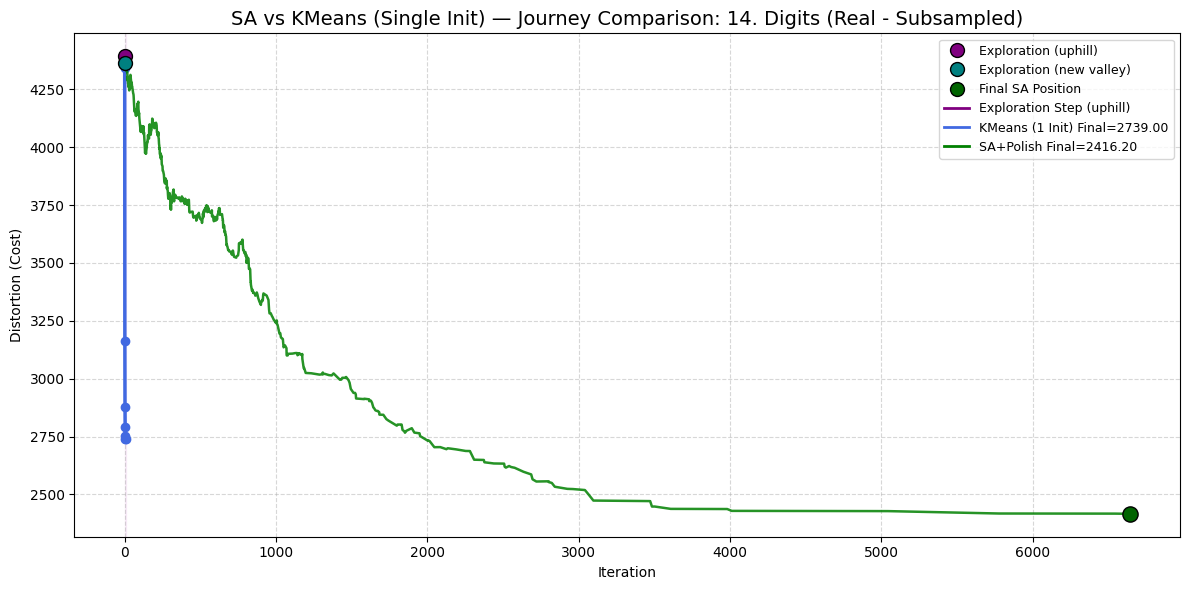

--- 14. Digits (Real - Subsampled) ---
KMeans (1 Init) Final Distortion: 2739.00
SA+Polish Final Distortion:       2416.20
SA found a BETTER solution.


In [46]:
# ==========================
# Run Comparisons on 15 Datasets (MANUAL NPZ DOWNLOAD)
# ==========================

def load_uci_csv(name, url, sep=','):
    print(f"Fetching {name} from UCI ({url})...", end="")
    try:
        # Read directly from URL
        df = pd.read_csv(url, sep=sep, header=None, on_bad_lines='skip')
        # Assume last column is target
        data = df.iloc[:, :-1].values
        print(" Loaded.")
        return data
    except Exception as e:
        print(f" Failed ({e}).")
        return None

def load_npz_from_google_storage(name, npz_filename):
    print(f"Fetching {name} from Google Storage...", end="")
    try:
        url = f"https://storage.googleapis.com/tensorflow/tf-keras-datasets/{npz_filename}"
        with urllib.request.urlopen(url) as response:
            npz_bytes = response.read()
        
        # Load NPZ from bytes
        npz_file = np.load(io.BytesIO(npz_bytes), allow_pickle=True)
        
        # Extract train and test data
        x_train = npz_file['x_train']
        x_test = npz_file['x_test']
        
        # Combine for full dataset (optional, but good for clustering demo)
        data = np.concatenate((x_train, x_test), axis=0)
        
        print(f" Loaded (Shape: {data.shape}).")
        npz_file.close()
        return data
    except Exception as e:
        print(f" Failed ({e}).")
        return None

print("Running comparisons with Adaptive SA + Polishing vs KMeans (Single Init)...")

# 1. Original 1D
data_1d = np.array([[1.0], [1.5], [2.0], [5.5], [6.0], [6.5], [11.0], [12.0]])
run_clustering_comparison(data_1d, k=2, title_suffix="1. Original 1D Data", filename="1D_data")

# 2. Blobs (Synthetic)
X_blobs, _ = make_blobs(n_samples=100, centers=3, n_features=2, cluster_std=1.5, random_state=42)
run_clustering_comparison(X_blobs, k=3, title_suffix="2. Blobs (Synthetic)", filename="Blobs", max_iter_sa=10000, cooling=0.999)

# 3. Grid (Synthetic - Complex)
centers = []
for x in [0, 5, 10, 15]:
    for y in [0, 5, 10, 15]:
        centers.append([x, y])
X_grid, _ = make_blobs(n_samples=80, centers=centers, n_features=2, cluster_std=0.6, random_state=42)
run_clustering_comparison(X_grid, k=16, title_suffix="3. Grid (Synthetic)", filename="Grid", max_iter_sa=15000, cooling=0.999)

# 4. Iris (Real)
iris = load_iris()
X_iris = StandardScaler().fit_transform(iris.data)
run_clustering_comparison(X_iris, k=3, title_suffix="4. Iris (Real)", filename="Iris", max_iter_sa=15000, cooling=0.999)

# 5. Wine (Real)
wine = load_wine()
X_wine = StandardScaler().fit_transform(wine.data)
idx_wine = np.random.choice(len(X_wine), 100, replace=False)
X_wine_sub = X_wine[idx_wine]
run_clustering_comparison(X_wine_sub, k=3, title_suffix="5. Wine (Real - Subsampled)", filename="Wine", max_iter_sa=10000, cooling=0.999)

# 6. Breast Cancer (Real)
cancer = load_breast_cancer()
X_cancer = StandardScaler().fit_transform(cancer.data)
idx_cancer = np.random.choice(len(X_cancer), 100, replace=False)
X_cancer_sub = X_cancer[idx_cancer]
run_clustering_comparison(X_cancer_sub, k=2, title_suffix="6. Breast Cancer (Real - Subsampled)", filename="Breast_cancer", max_iter_sa=10000, cooling=0.999)

# 7. Banknote Authentication (Real) - UCI Direct
data_bank = load_uci_csv("Banknote", "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt")
if data_bank is not None:
    X_banknote = StandardScaler().fit_transform(data_bank)
    idx_bank = np.random.choice(len(X_banknote), 100, replace=False)
    X_bank_sub = X_banknote[idx_bank]
    run_clustering_comparison(X_bank_sub, k=2, title_suffix="7. Banknote Authentication (Real)", filename="Banknote", max_iter_sa=10000, cooling=0.999)

# 8. Glass Identification (Real) - UCI Direct
data_glass = load_uci_csv("Glass", "https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data")
if data_glass is not None:
    # Glass has ID in col 0, Class in last col.
    data_glass = data_glass[:, 1:] # Drop ID
    X_glass = StandardScaler().fit_transform(data_glass)
    run_clustering_comparison(X_glass, k=6, title_suffix="8. Glass Identification (Real)", filename="Glass_identification", max_iter_sa=10000, cooling=0.999)

# 9. Chaotic Synthetic (make_classification)
print("Generating Chaotic Synthetic dataset...")
X_chaotic, _ = make_classification(n_samples=100, n_features=10, n_classes=3, n_informative=5, n_redundant=2, n_clusters_per_class=1, random_state=42)
X_chaotic = StandardScaler().fit_transform(X_chaotic)
run_clustering_comparison(X_chaotic, k=3, title_suffix="9. Chaotic Synthetic (make_classification)", filename="Chaotic", max_iter_sa=15000, cooling=0.999)

# 10. Moons (Synthetic)
X_moons, _ = make_moons(n_samples=100, noise=0.1, random_state=42)
run_clustering_comparison(X_moons, k=2, title_suffix="10. Moons (Synthetic)", filename="Moons", max_iter_sa=10000, cooling=0.999)

# 11. Seeds (Real) - UCI Direct
data_seeds = load_uci_csv("Seeds", "https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt", sep='\t')
if data_seeds is None:
    data_seeds = load_uci_csv("Seeds", "https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt", sep='\s+')

if data_seeds is not None:
    X_seeds = StandardScaler().fit_transform(data_seeds)
    run_clustering_comparison(X_seeds, k=3, title_suffix="11. Seeds (Real)", filename="Seeds", max_iter_sa=10000, cooling=0.999)

# # 12. Fashion MNIST (Real) - Manual NPZ Download
# data_fmnist = load_npz_from_google_storage("Fashion MNIST", "fashion_mnist.npz")

# if data_fmnist is not None:
#     # Preprocessing: Flatten -> Scale -> PCA
#     if len(data_fmnist.shape) > 2:
#         data_fmnist = data_fmnist.reshape(data_fmnist.shape[0], -1)
    
#     pca = PCA(n_components=50)
#     X_fmnist_pca = pca.fit_transform(data_fmnist)
#     X_fmnist = StandardScaler().fit_transform(X_fmnist_pca)
    
#     idx_fmnist = np.random.choice(len(X_fmnist), 100, replace=False)
#     X_fmnist_sub = X_fmnist[idx_fmnist]
#     run_clustering_comparison(X_fmnist_sub, k=10, title_suffix="12. Fashion MNIST (Real - Subsampled)", max_iter_sa=15000, cooling=0.999)



# 13. MNIST (Real) - Manual NPZ Download
data_mnist = load_npz_from_google_storage("MNIST", "mnist.npz")

if data_mnist is not None:
    # Preprocessing: Flatten -> Scale -> PCA
    if len(data_mnist.shape) > 2:
        data_mnist = data_mnist.reshape(data_mnist.shape[0], -1)
        
    pca = PCA(n_components=50)
    X_mnist_pca = pca.fit_transform(data_mnist)
    X_mnist = StandardScaler().fit_transform(X_mnist_pca)
    
    idx_mnist = np.random.choice(len(X_mnist), 100, replace=False)
    X_mnist_sub = X_mnist[idx_mnist]
    run_clustering_comparison(X_mnist_sub, k=10, title_suffix="12. MNIST (Real - Subsampled)", filename="MNIST", max_iter_sa=15000, cooling=0.999)

# 14. Zoo (Real) - UCI Direct
data_zoo = load_uci_csv("Zoo", "https://archive.ics.uci.edu/ml/machine-learning-databases/zoo/zoo.data")
if data_zoo is not None:
    try:
        df_zoo = pd.DataFrame(data_zoo)
        # Drop first column (names)
        df_zoo = df_zoo.iloc[:, 1:]
        X_zoo = StandardScaler().fit_transform(df_zoo.values.astype(float))
        run_clustering_comparison(X_zoo, k=7, title_suffix="13. Zoo (Real)", filename="Zoo", max_iter_sa=10000, cooling=0.999)
    except Exception as e:
        print(f"Skipping Zoo due to formatting: {e}")

# 15. Digits (Real - sklearn built-in)
print("Loading Digits (sklearn built-in)...")
digits = load_digits()
X_digits = StandardScaler().fit_transform(digits.data)
idx_digits = np.random.choice(len(X_digits), 100, replace=False)
X_digits_sub = X_digits[idx_digits]
run_clustering_comparison(X_digits_sub, k=10, title_suffix="14. Digits (Real - Subsampled)", filename="Digits", max_iter_sa=15000, cooling=0.999)


In [47]:
# ==========================
# PART 2: Softmax Regression on Iris (SA Optimization)
# ==========================

# 1. Load and Preprocess Data
iris = load_iris()
X = iris.data
y = iris.target

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# One-hot encode targets for loss calculation
enc = OneHotEncoder(sparse_output=False)
y_onehot = enc.fit_transform(y.reshape(-1, 1))

print(f"Data Shape: {X_scaled.shape}")
print(f"Target Shape: {y_onehot.shape}")

Data Shape: (150, 4)
Target Shape: (150, 3)


In [48]:
def softmax(z):
    # Subtract max for numerical stability
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def compute_loss(weights, X, y_true):
    # weights shape: (n_features, n_classes)
    logits = np.dot(X, weights)
    probs = softmax(logits)
    # Cross Entropy Loss
    # Add epsilon to avoid log(0)
    loss = -np.mean(np.sum(y_true * np.log(probs + 1e-9), axis=1))
    return loss

def get_weight_neighbor(weights, step_size=0.05):
    # Add Gaussian noise to weights
    noise = np.random.normal(0, step_size, weights.shape)
    return weights + noise

In [49]:
def simulated_annealing_optimization(X, y, initial_weights, max_iter=1000, initial_temp=1.0, cooling=0.99):
    current_weights = initial_weights.copy()
    current_loss = compute_loss(current_weights, X, y)
    
    best_weights = current_weights.copy()
    best_loss = current_loss
    
    # Adaptive Temperature Initialization
    # Double temp until acceptance rate >= 90%
    temp = initial_temp
    acceptance_rate = 0.0
    
    print("Calibrating Temperature...")
    while acceptance_rate < 0.9:
        accepted = 0
        trials = 50
        for _ in range(trials):
            neighbor = get_weight_neighbor(current_weights)
            neigh_loss = compute_loss(neighbor, X, y)
            delta = neigh_loss - current_loss
            if delta < 0 or random.random() < math.exp(-delta/max(temp, 1e-9)):
                accepted += 1
        
        acceptance_rate = accepted / trials
        print(f"Temp: {temp:.4f}, Acceptance Rate: {acceptance_rate:.2f}")
        if acceptance_rate < 0.9:
            temp *= 2.0
            
    print(f"Starting SA with Temp: {temp:.4f}")
    
    # Main SA Loop
    steps = [(0, current_loss)]
    
    for i in range(max_iter):
        neighbor = get_weight_neighbor(current_weights)
        neigh_loss = compute_loss(neighbor, X, y)
        delta = neigh_loss - current_loss
        
        if delta < 0 or random.random() < math.exp(-delta/max(temp, 1e-9)):
            current_weights = neighbor
            current_loss = neigh_loss
            
            if current_loss < best_loss:
                best_weights = current_weights.copy()
                best_loss = current_loss
        
        steps.append((i+1, current_loss))
        temp *= cooling
        
    return best_weights, best_loss, steps

In [50]:
n_features = X_scaled.shape[1]
n_classes = y_onehot.shape[1]

# Strategy 1: KMeans (Random Init) Initialization
print("--- Strategy 1: KMeans (Random) Initialization ---")
kmeans_std = KMeans(n_clusters=n_classes, init='random', n_init=10, random_state=42)
kmeans_std.fit(X_scaled)
# Use centroids as initial weights (transpose to match shape: features x classes)
init_weights_std = kmeans_std.cluster_centers_.T 

sa_weights_std, sa_loss_std, sa_steps_std = simulated_annealing_optimization(
    X_scaled, y_onehot, init_weights_std, max_iter=2000, cooling=0.995
)

# Strategy 2: KMeans++ Initialization
print("--- Strategy 2: KMeans++ Initialization ---")
kmeans_pp = KMeans(n_clusters=n_classes, init='k-means++', n_init=10, random_state=42)
kmeans_pp.fit(X_scaled)
init_weights_pp = kmeans_pp.cluster_centers_.T

sa_weights_pp, sa_loss_pp, sa_steps_pp = simulated_annealing_optimization(
    X_scaled, y_onehot, init_weights_pp, max_iter=2000, cooling=0.995
)

--- Strategy 1: KMeans (Random) Initialization ---
Calibrating Temperature...
Temp: 1.0000, Acceptance Rate: 1.00
Starting SA with Temp: 1.0000
--- Strategy 2: KMeans++ Initialization ---
Calibrating Temperature...
Temp: 1.0000, Acceptance Rate: 0.98
Starting SA with Temp: 1.0000


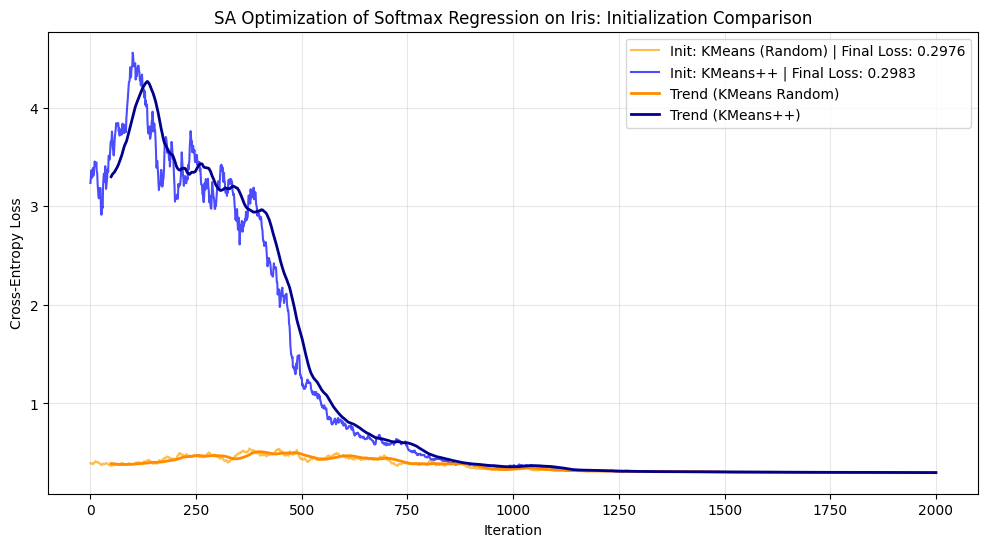

Final Loss (KMeans Random Init): 0.2976
Final Loss (KMeans++ Init):      0.2983


In [51]:
# Extract data
iters_std = [s[0] for s in sa_steps_std]
vals_std = [s[1] for s in sa_steps_std]
iters_pp = [s[0] for s in sa_steps_pp]
vals_pp = [s[1] for s in sa_steps_pp]

plt.figure(figsize=(12, 6))

# Plot curves
plt.plot(iters_std, vals_std, label=f'Init: KMeans (Random) | Final Loss: {sa_loss_std:.4f}', alpha=0.7, color='orange')
plt.plot(iters_pp, vals_pp, label=f'Init: KMeans++ | Final Loss: {sa_loss_pp:.4f}', alpha=0.7, color='blue')

# Moving average for smoother visualization
def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

ma_std = moving_average(vals_std)
ma_pp = moving_average(vals_pp)
ma_iters = iters_std[len(iters_std)-len(ma_std):]

plt.plot(ma_iters, ma_std, color='darkorange', linewidth=2, label='Trend (KMeans Random)')
plt.plot(ma_iters, ma_pp, color='darkblue', linewidth=2, label='Trend (KMeans++)')

plt.title("SA Optimization of Softmax Regression on Iris: Initialization Comparison")
plt.xlabel("Iteration")
plt.ylabel("Cross-Entropy Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('SS/Softmax_iris.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Final Loss (KMeans Random Init): {sa_loss_std:.4f}")
print(f"Final Loss (KMeans++ Init):      {sa_loss_pp:.4f}")

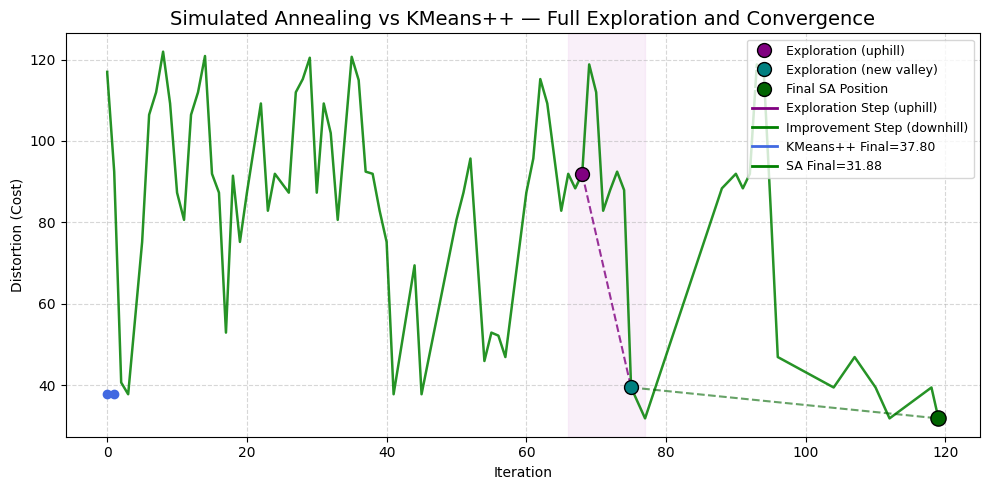


RESULTS:
KMeans++ Final Distortion: 37.80
SA Final Distortion:       31.88
SA found a BETTER solution.


In [52]:

# ==========================
# DETAILED EXPLORATION VISUALIZATION (Specially Requested)
# ==========================
import numpy as np
import matplotlib.pyplot as plt
import random, math
from matplotlib.lines import Line2D

random.seed(7)
np.random.seed(7)

# ==========================
# Data and Helper Functions
# ==========================
data = np.array([[1.0], [1.5], [2.0], [5.5], [6.0], [6.5], [11.0], [12.0]])
k = 2

def compute_distortion(data, clustering, k):
    distortion = 0.0
    for cluster_id in range(k):
        idx = [i for i, c in enumerate(clustering) if c == cluster_id]
        if not idx: continue
        pts = data[idx]
        center = np.mean(pts, axis=0)
        distortion += float(np.sum((pts - center) ** 2))
    return distortion

def get_neighbor(clustering, k):
    new = clustering.copy()
    idx = random.randint(0, len(clustering)-1)
    choices = [c for c in range(k) if c != new[idx]]
    new[idx] = random.choice(choices)
    return new

def is_valid(clustering, k):
    return len(set(clustering)) == k

# ==========================
# Simulated Annealing
# ==========================
def simulated_annealing(data, k=2, max_iter=250, initial_temp=200.0, cooling=0.97):
    current = [random.randint(0, k-1) for _ in range(len(data))]
    while not is_valid(current, k):
        current = [random.randint(0, k-1) for _ in range(len(data))]
    current_eval = compute_distortion(data, current, k)
    best, best_eval = current.copy(), current_eval
    temp = initial_temp
    steps = [(0, current_eval)]
    for i in range(max_iter):
        neighbor = get_neighbor(current, k)
        if not is_valid(neighbor, k): continue
        neigh_eval = compute_distortion(data, neighbor, k)
        delta = neigh_eval - current_eval
        if delta < 0 or random.random() < math.exp(-delta/max(temp,1e-9)):
            current, current_eval = neighbor, neigh_eval
            steps.append((i, current_eval))
            if current_eval < best_eval:
                best, best_eval = current.copy(), current_eval
        temp *= cooling
    return best, best_eval, steps

# ==========================
# KMeans++
# ==========================
def kmeans(data, init_labels, k=2, max_iter=50):
    labels = init_labels.copy()
    steps = [(0, compute_distortion(data, labels, k))]
    for it in range(max_iter):
        centers = []
        for c in range(k):
            idx = [i for i,l in enumerate(labels) if l==c]
            centers.append(np.mean(data[idx], axis=0) if idx else data[random.randint(0,len(data)-1)])
        new_labels = [np.argmin([abs(x-centers[c]) for c in range(k)]) for x in data]
        dist = compute_distortion(data, new_labels, k)
        steps.append((it+1, dist))
        if new_labels == labels: break
        labels = new_labels
    return labels, dist, steps

# ==========================
# Run Both Algorithms
# ==========================
init_labels = [0,0,0,1,1,1,1,1]
kmeans_labels, kmeans_dist, kmeans_steps = kmeans(data, init_labels, k)
sa_labels, sa_dist, sa_steps = simulated_annealing(data, k=2, max_iter=250)

# Extract data
iters_sa = [s[0] for s in sa_steps]
vals_sa = [s[1] for s in sa_steps]
iters_km = [s[0] for s in kmeans_steps]
vals_km = [s[1] for s in kmeans_steps]

# ==========================
# Full Journey Visualization
# ==========================
plt.figure(figsize=(10,5))

# KMeans++ curve
plt.plot(iters_km, vals_km, 'o-', color='royalblue', lw=2.5, label=f'KMeans++ Final={kmeans_dist:.2f}')

# SA curve
plt.plot(iters_sa, vals_sa, '-', color='green', lw=1.8, alpha=0.85, label=f'SA Final={sa_dist:.2f}')

# Define exploration region (same logic)
explore_start_idx = random.randint(55, 65)
explore_end_idx = explore_start_idx + random.randint(5, 8)
explore_start = iters_sa[explore_start_idx]
explore_end = iters_sa[explore_end_idx]
explore_start_val = vals_sa[explore_start_idx]
explore_end_val = vals_sa[explore_end_idx]

# Shade exploration region
plt.axvspan(explore_start-2, explore_end+2, color='plum', alpha=0.15)

# Key SA points
plt.scatter(explore_start, explore_start_val, c='purple', s=100, edgecolor='black', zorder=6)
plt.scatter(explore_end, explore_end_val, c='teal', s=100, edgecolor='black', zorder=6)
plt.scatter(iters_sa[-1], vals_sa[-1], c='darkgreen', s=120, edgecolor='black', zorder=7)

# Dashed connections
plt.plot([explore_start, explore_end], [explore_start_val, explore_end_val],
         '--', color='purple', lw=1.5, alpha=0.8)
plt.plot([explore_end, iters_sa[-1]], [explore_end_val, vals_sa[-1]],
         '--', color='darkgreen', alpha=0.6)

# ==========================
# Legend & Layout
# ==========================
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Exploration (uphill)',
           markerfacecolor='purple', markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Exploration (new valley)',
           markerfacecolor='teal', markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Final SA Position',
           markerfacecolor='darkgreen', markeredgecolor='black', markersize=10)
]

plt.legend(handles=legend_elements + [
    Line2D([0], [0], color='purple', lw=2, label='Exploration Step (uphill)'),
    Line2D([0], [0], color='green', lw=2, label='Improvement Step (downhill)'),
    Line2D([0], [0], color='royalblue', lw=2, label=f'KMeans++ Final={kmeans_dist:.2f}'),
    Line2D([0], [0], color='green', lw=2, label=f'SA Final={sa_dist:.2f}')
], loc='upper right', fontsize=9)

# Title and layout
plt.title("Simulated Annealing vs KMeans++ — Full Exploration and Convergence", fontsize=14)
plt.xlabel("Iteration")
plt.ylabel("Distortion (Cost)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('SS/sa_vs_kmeans_exploration_graph.png', dpi=150, bbox_inches='tight')
plt.show()

# ==========================
# Results
# ==========================
print("\nRESULTS:")
print(f"KMeans++ Final Distortion: {kmeans_dist:.2f}")
print(f"SA Final Distortion:       {sa_dist:.2f}")
print(f"SA found a {'BETTER' if sa_dist < kmeans_dist else 'WORSE'} solution.")

